In [1]:
#train
IMG_TRAIN_DIR =  '/content/drive/MyDrive/For Project/Segmentation/Training Data/images'
MASK_TRAIN_DIR = '/content/drive/MyDrive/For Project/Segmentation/Training Data/maska'
IMG_TEST_DIR = '/content/drive/MyDrive/For Project/Segmentation/Validation Data/images'
MASK_TEST_DIR = '/content/drive/MyDrive/For Project/Segmentation/Validation Data/masks'

In [2]:
import os
from tqdm import tqdm
import cv2
import numpy as np

img_train = []
img_test = []
mask_train = []
mask_test = []

def load_train_data(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img /255
        img_train.append(np.array(img))

load_train_data(IMG_TRAIN_DIR)

def load_test_data(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img /255
        img_test.append(np.array(img))

load_test_data(IMG_TEST_DIR)

def load_train_mask(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img /255
        mask_train.append(np.array(img))

load_train_mask(MASK_TRAIN_DIR)

def load_test_mask(DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256,256))
        img = img /255
        mask_test.append(np.array(img))

load_test_mask(MASK_TEST_DIR)

100%|██████████| 76/76 [00:02<00:00, 26.10it/s]


In [3]:
img_train = np.array(img_train)
mask_train = np.array(mask_train)

img_test = np.array(img_test)
mask_test = np.array(mask_test)

In [4]:
print(np.shape(img_train))
print(np.shape(mask_train))
print(np.shape(img_test))
print(np.shape(mask_test))


(762, 256, 256, 3)
(762, 256, 256, 3)
(76, 256, 256, 3)
(76, 256, 256, 3)


In [5]:
import tensorflow as tf

training_dataset = tf.data.Dataset.from_tensor_slices((img_train,mask_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((img_test,mask_test))

training_dataset.shuffle(1000).repeat()

<RepeatDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float64, name=None))>

In [6]:
train_batches = training_dataset.cache().shuffle(1000).batch(32).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = validation_dataset.take(3000).batch(32)



In [7]:
for element in training_dataset:
  print(element)

Streaming output truncated to the last 5000 lines.
        [0., 0., 0.]]])>, <tf.Tensor: shape=(256, 256, 3), dtype=float64, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.

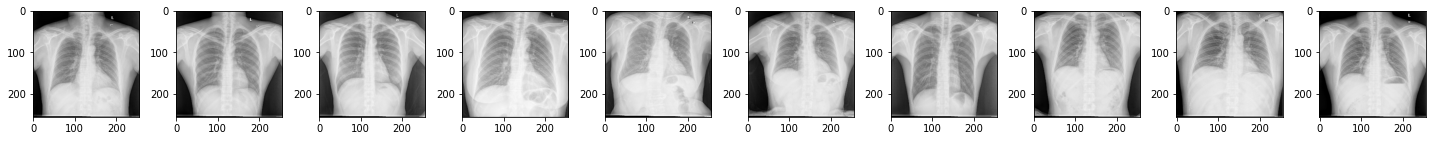

In [8]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,10)
fig.set_size_inches(20,20)
l=0
for i in range(10):
      ax[i].imshow(img_train[i])
                

plt.tight_layout()


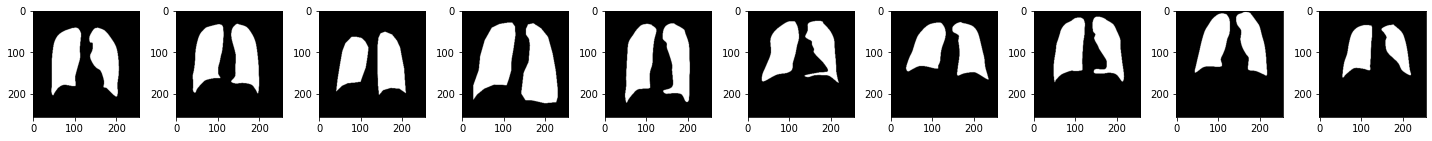

In [9]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,10)
fig.set_size_inches(20,20)
l=0
for i in range(10):
  ax[i].imshow(mask_train[i])
                

plt.tight_layout()


In [10]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(256,256,3))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x


# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(s, 64)
# 2 - downsample
f2, p2 = downsample_block(p1, 128)
# 3 - downsample
f3, p3 = downsample_block(p2, 256)
# 4 - downsample
f4, p4 = downsample_block(p3, 512)
# 5 - bottleneck
bottleneck = double_conv_block(p4, 1024)
# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 512)
# 7 - upsample
u7 = upsample_block(u6, f3, 256)
# 8 - upsample
u8 = upsample_block(u7, f2, 128)
# 9 - upsample
u9 = upsample_block(u8, f1, 64)
# outputs
outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
# unet model with Keras Functional API
unet_model = tf.keras.Model([inputs], [outputs], name="U-Net")

unet_model.compile(optimizer="adam", loss="binary_crossentropy", loss_weights=[0.5,0.5], metrics=['binary_accuracy'])

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint("segmentation.h5", monitor='binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='binary_accuracy', min_delta=0, patience=20, verbose=1, mode='min')

unet_model.fit(train_batches, epochs=10, # one forward/backward pass of training dataages comprising of one epoch
                    validation_data=validation_batches,callbacks=[early,checkpoint], steps_per_epoch=10
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 4.6670 - binary_accuracy: 0.7185
Epoch 1: binary_accuracy improved from -inf to 0.71848, saving model to segmentation.h5
10/10 [==============================] - 20s 1s/step - loss: 4.6670 - binary_accuracy: 0.7185 - val_loss: 0.3413 - val_binary_accuracy: 0.7090
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.7325
Epoch 2: binary_accuracy improved from 0.71848 to 0.73252, saving model to segmentation.h5
10/10 [==============================] - 11s 1s/step - loss: 0.3385 - binary_accuracy: 0.7325 - val_loss: 0.3363 - val_binary_accuracy: 0.7090
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.3323 - binary_accuracy: 0.7261
Epoch 3: binary_accuracy did not improve from 0.73252
10/10 [==============================] - 14s 1s/step - loss: 0.3323 - binary_accuracy: 0.7261 - val_loss: 0.3289 - val_binary_accuracy: 0.7090
Epoch 4/10
10/10 [=================

In [ ]:
import ipyplot

my_predictions = unet_model.predict(img_test)

print(np.shape(my_predictions))

my_predictions = my_predictions[-1]

print(my_predictions.shape)


my_predictions = np.asarray(my_predictions*255).astype(np.uint8)
print(my_predictions.shape)


for i in range(len(my_predictions)):
  my_predictions[i,...] = cv2.threshold(my_predictions[i,...], 0, 1, cv2.THRESH_OTSU)[1]



ground_truths_masks = np.asarray(mask_test, dtype=np.uint8)
my_predictions = np.asarray(my_predictions, dtype=np.uint8)

print(np.shape(ground_truths_masks), np.shape(my_predictions))

ipyplot.plot_images(testing_masks*255, max_images=10, img_width=150)
ipyplot.plot_images(my_predictions*255, max_images=10, img_width=150)

my_predictions = my_predictions.reshape(my_predictions.shape[0] * my_predictions.shape[1] * my_predictions.shape[2],1)
ground_truths_masks = ground_truths_masks.reshape(ground_truths_masks.shape[0] * ground_truths_masks.shape[1]
                                                  * ground_truths_masks.shape[2],1)
validation_accuracy = f1_score(ground_truths_masks, my_predictions, average='binary')

print('F1 score: ', validation_accuracy)

